# 🇹🇼 DWthon 4.0 - прогнозирование банкротства фирм в Тайване (на реальных данных) 🇹🇼


Начало будет похожим, как в предыдущих стартерах -  просто прокликаем.

## 📥 Импортируем нужные библиотеки

In [10]:
import pandas as pd
import numpy as np
np.random.seed(0)

import catboost as ctb
import xgboost as xgb
import lightgbm as lgb
from sklearn.metrics import f1_score, classification_report


from sklearn.model_selection import StratifiedKFold, cross_val_score
import eli5
from eli5.sklearn import PermutationImportance

import scikitplot as skplt

import matplotlib.pyplot as plt

## 🗃️  Загружаем данные

In [11]:
df_train = pd.read_hdf("../input/train_taiwan.h5")
df_test = pd.read_hdf("../input/test_taiwan.h5")

df_all = pd.concat([df_train, df_test]).reset_index(drop=True)
df_all.columns = [x.replace(" ", "_").lower() for x in df_all.columns]

df_train.shape, df_test.shape, df_all.shape

((3409, 97), (3410, 96), (6819, 97))

## 🤖 Функция-помощник

Теперь мы больше не будем использовать `cross_val_score`, а сделаем свою собственную - немного больше кода, но больше гибкости, что в данном случае необходимо.

In [12]:
def make_experiment(model, feats=None, threshold=0.5, n_splits=3, black_list=["target"], show_feats=False, show_cr=False, show_cm=False, show_pr=False, show_lc=False):
    if feats is None:
        num_feats = df_all.select_dtypes("number").columns
        feats = [x for x in num_feats if x not in black_list]

    if show_feats:
        print(feats)
        
    df_train = df_all[ df_all["target"].notnull() ]
    X_train = df_train[feats].values
    y_train = df_train["target"].values

    scores = []
    cv=StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=0)
    for train_idx, test_idx in cv.split(X_train, y_train):    

        model.fit(X_train[train_idx], y_train[train_idx])

        y_probas = model.predict_proba(X_train[test_idx])
        y_pred = (y_probas[:,1] > threshold).astype(np.int)
        #y_pred = model.predict(X_train[test_idx])

        if show_cr:
            print(classification_report(y_train[test_idx], y_pred))
        
        if show_cm:
            skplt.metrics.plot_confusion_matrix(y_train[test_idx], y_pred)#normalize=True
            
        if show_pr:
            skplt.metrics.plot_precision_recall(y_train[test_idx], y_probas)

        score = f1_score(y_train[test_idx], y_pred)
        scores.append(score)

    
    
    print("Score: ", np.mean(scores), np.std(scores))
    
    skplt.estimators.plot_learning_curve(model, X_train, y_train, cv=cv, scoring="f1", random_state=0)
    
    return eli5.show_weights(model, feature_names=feats, top=50)
    
    
def my_hist(df_all, feat_name, left_perc=1, right_perc=99):
    min_value = np.percentile( df_all[feat_name], 1)
    max_value = np.percentile( df_all[feat_name], 99)

    (
        df_all[ 
            (df_all[feat_name] > min_value) &
            (df_all[feat_name] < max_value)
        ][feat_name]
    ).hist(bins=100)
    plt.title("{}\n, left_perc={}, right_perc={}".format(feat_name, left_perc, right_perc))
    plt.show()
    
    
def save_result(filename, model, threshold=0.1):

    df_train = df_all[ df_all["target"].notnull() ]
    df_test = df_all[ df_all["target"].isnull() ].copy()

    num_feats = df_all.select_dtypes("number").columns
    feats = [x for x in num_feats if x not in ["target"]]

    
    model.fit(df_train[feats].values, df_train["target"].values)

    df_test["target"] = (model.predict_proba(df_test[feats].values)[:,1] > 0.1).astype(np.int)
    output_file = "../output/{}".format(filename)
    df_test[ ["id", "target"] ].to_csv(output_file, index=False)
    print("Saved: ", output_file)

## 🧐 Экспериментируем

Score:  0.4326876826876827 0.02803963590288893


Weight,Feature
0.0603,continuous_profit_rate_(after_tax)
0.0495,persistent_eps_in_the_last_four_seasons
0.0493,working_capital/equity
0.0486,roa(a)_after_tax_and_before_interest%
0.0420,"roa(b)_after_tax_and_before_interest,_before_depreciation"
0.0401,net_income_to_total_assets
0.0312,tax_rate_(a)
0.0244,total_debt/total_net_worth
0.0242,roa(c)_before_tax_and_interest_before_depreciation
0.0242,book_value_per_share_(b)


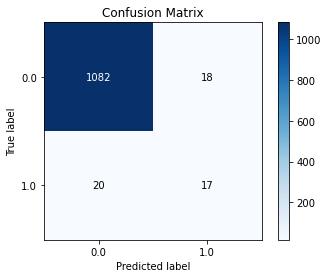

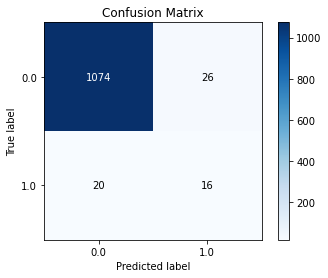

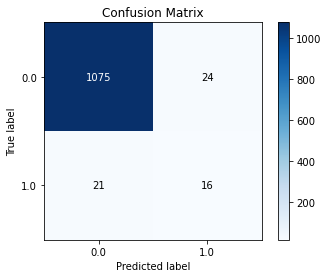

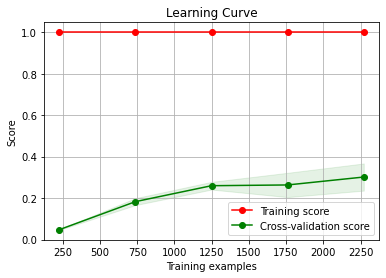

In [13]:
model = xgb.XGBClassifier(max_depth=5, n_estimators=100, random_state=0)
make_experiment(model, threshold=0.1, show_cm=True)

## Имеем результат
`Score: 0.4326876826876827 0.02803963590288893`.


Результат, выглядит немного иначе, чем раньше (хотя модель и признаки те же). Почему такая разница?

Я установил валидацию по-другому, чтобы сделать ее более "случайной", и результаты в каждой итерации повторялись.
```
cv=StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=0)
```

Теперь, как видишь в `confusion_matrix`, результаты всех трех итераций более схожи.


### Давай подумаем, что еще мы можем сделать?

У нас есть как минимум несколько путей:
- поиск лучших признаков (англ. `feature engineering`)
- более сложная модель
- объединение нескольких моделей
- танцы с бубном (хотя это не всегда помогает 😂)

Score:  0.43061538689286616 0.033742663692361445


Weight,Feature
0.0540,cash_/_current_liability
0.0480,interest-bearing_debt_interest_rate
0.0424,roa(c)_before_tax_and_interest_before_depreciation
0.0335,total_income_/_total_expense
0.0334,continuous_profit_rate_(after_tax)
0.0321,retained_earnings/total_assets
0.0316,equity_to_long-term_liability
0.0292,accounts_receivable_turnover
0.0249,net_income_to_total_assets
0.0237,equipment_rate_per_person


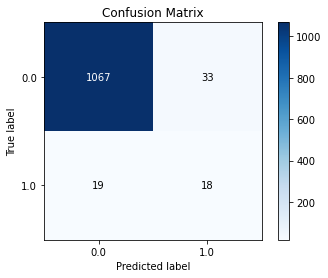

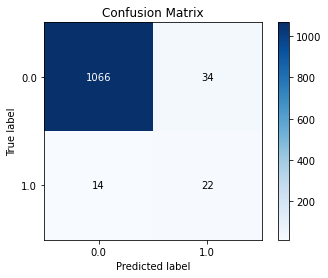

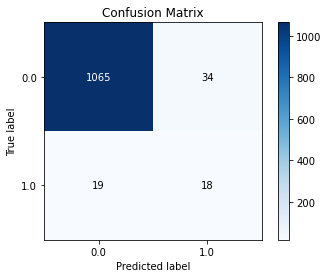

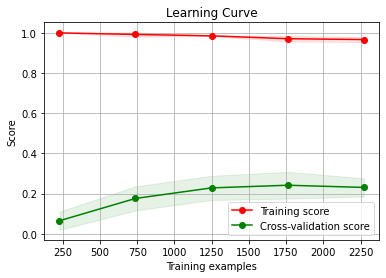

In [14]:
model = ctb.CatBoostClassifier(max_depth=5, n_estimators=100, verbose=0)
make_experiment(model, threshold=0.1, show_cm=True)

In [ ]:
model = lgb.LGBMClassifier(max_depth=5, n_estimators=100)
make_experiment(model, threshold=0.1, show_cm=True)

Score:  0.464243955932228 0.03206665746593907


Score:  0.3977166624225448 0.029138732756977398


Weight,Feature
0.1162,continuous_profit_rate_(after_tax)
0.0881,book_value_per_share_(b)
0.0689,interest-bearing_debt_interest_rate
0.0508,borrowing_dependency
0.0415,net_worth_growth_rate
0.0337,retained_earnings/total_assets
0.0306,cash_/_current_liability
0.0276,total_assets_growth_rate_
0.0263,roa(c)_before_tax_and_interest_before_depreciation
0.0243,net_value/asset


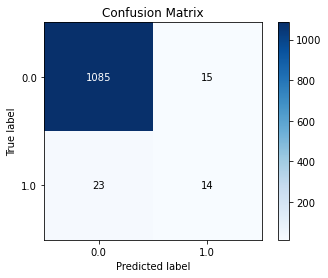

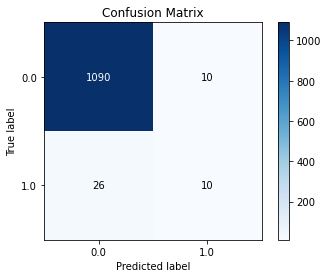

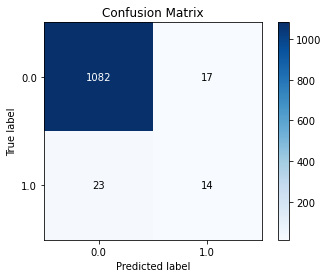

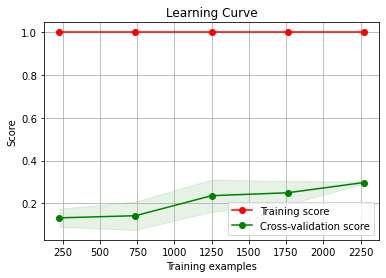

In [9]:
model = lgb.LGBMClassifier(max_depth=4, n_estimators=250)
make_experiment(model, threshold=0.1, show_cm=True)

Score:  0.42340717488377644 0.023378331410423524


Weight,Feature
0.1164,continuous_profit_rate_(after_tax)
0.0882,book_value_per_share_(b)
0.0689,interest-bearing_debt_interest_rate
0.0509,borrowing_dependency
0.0416,net_worth_growth_rate
0.0338,retained_earnings/total_assets
0.0307,cash_/_current_liability
0.0276,total_assets_growth_rate_
0.0263,roa(c)_before_tax_and_interest_before_depreciation
0.0243,net_value/asset


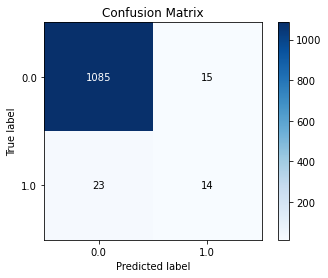

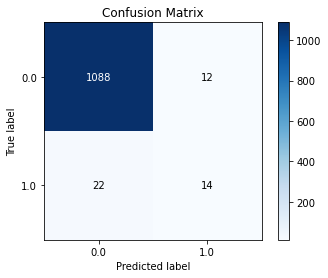

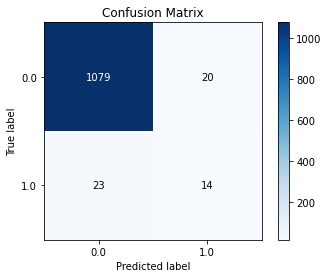

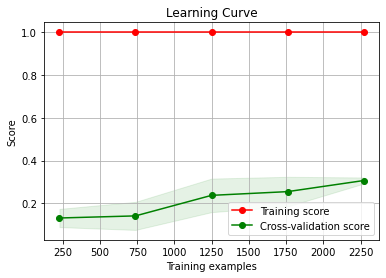

In [8]:
model = lgb.LGBMClassifier(max_depth=4, n_estimators=220)
make_experiment(model, threshold=0.1, show_cm=True)

Обрати внимание, что каждая модель уделяет внимание немного разным признакам, также по-разному ведет себя `confusion matrix`.



## 🌎 Submit

Давай запишем результаты `ctb` и `lgb`.

In [22]:
model = lgb.LGBMClassifier(max_depth=4, n_estimators=250)
save_result("lgb_threshold_0.1_em.csv", model)

Saved:  ../output/lgb_threshold_0.1_em.csv


In [8]:
model = ctb.CatBoostClassifier(max_depth=5, n_estimators=100, verbose=0)
save_result("ctb_threshold_0.1.csv", model)

Saved:  ../output/ctb_threshold_0.1.csv


## 🤝 Мы объединяем модели

Теперь мы можем попытаться объединить модели - на пркатике мы объединяем результаты этих моделей.

In [11]:
xgb_output = pd.read_csv("../output/xgb_threshold_0.1.csv")
lgb_output = pd.read_csv("../output/lgb_threshold_0.1.csv")
ctb_output = pd.read_csv("../output/ctb_threshold_0.1.csv")

(0.60*xgb_output["target"] + 0.15*lgb_output["target"] + 0.25*ctb_output["target"]).value_counts()

0.00    3196
1.00      83
0.25      48
0.40      27
0.15      25
0.85      20
0.60       7
0.75       4
Name: target, dtype: int64

Как видишь, у нас есть кое-что «посередине»

```
0.33      55
0.67      31
0.34      25
0.66      20
```

К какому классу отнести - решать Тебе, пока что я взял достаточно стандартные веса (0.33 и 0.34 для одной модели) и если они больше 0.2, то даем 1. Поймать 1 выгоднее, чем потерять 🤔. Но Ты все равно можешь немного покомбинировать здесь.

In [10]:
output = pd.DataFrame()
output["id"] = xgb_output["id"]
output["target"] = ((0.33*xgb_output["target"] + 0.34*lgb_output["target"] + 0.33*ctb_output["target"]) > 0.2).astype(np.int)

output.to_csv("../output/0.33xgb_0.34lgb_0.33ctb.csv", index=False)

## ☝️ Остерегайся `overfitting`.

В несбалансированных данных справиться с переобучением сложнее, поэтому тщательно настраивай свою модель, а также можно ожидать `mixer/overfitting` в Твоем Kaggle, что означает, что `Public LeaderBoard` будет отличаться от `Private Leaderboard`.


## 🤝🗣️ Совместное обсуждение и обмен опытом 💬
Соревнование соревнованием, но во всем этом есть нечто большее, чем победа...

👉 *сотрудничество, общение, творческое и критическое мышление* - это ценности и навыки, о которых стоит заботиться

Прежде всего, речь идет о том, чтобы как можно больше учиться и поддерживать друг друга. Помни о здоровой конкуренции и взаимной помощи
🤝 

Для проведения конкурса в Kaggle мы создали отдельные каналы:
- [#dwthon_general](https://dataworkshop-ru.slack.com/archives/C02NRMNLE2D) - **общий канал**
- [#dwthon_ideas](https://dataworkshop-ru.slack.com/archives/C02N6CBK1CN) - **канал, где можно делиться мыслями и идеями**
- [#dwthon_questions](https://dataworkshop-ru.slack.com/archives/C02N6C69G3Y) - **канал, где можно задавать вопросы**

## 👉 Задания для тебя: 

1. Сделай starter2
2. Подумай надновыми признаками
3. Сделай эксперимент 
4. Поделись своими лучшими решениями в Kaggle

## 👉 Следующий шаг... 

### Подведение итогов конкурса 🥳

## `DW Club`, вот некоторые факты о нем:
- Участники `DW Club` имеют доступ к материалам 24/7
- Этот интенсив - еще один материал для `DW Club`, и с каждым месяцем их число будет только расти.
- Членам `DW Club` гарантированы более выгодные условия приобретения платных курсов и т.д.

Узнай больше и посмотри, что нас ждет [перейдя по ссылке](https://dataworkshop.ru/data-science/dw-club).